# Análise Preditiva Avançada

## Bibliotecas

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

from time import strptime

from sklearn.externals import joblib

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.metrics import confusion_matrix, classification_report

warnings.filterwarnings('ignore')

## Carregamento dos dados

In [2]:
SEED = 314

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/lsnascimento/apa/master/input/Marketing.csv', sep=';')
df2 = df.copy()

In [4]:
print('Rows: %s\nCols: %s\n' % df.shape)

df.head()

Rows: 41188
Cols: 19



,AGE,JOB,MARITAL_STATUS,EDUCATION,DEFAULT,HOUSING,LOAN,CONTACT,MONTH,DAY_OF_WEEK,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,EMP_VAR_RATE,CONS_PRICE_IDX,CONS_CONF_IDX,SUBSCRIBED
0,56,housemaid,married,basic_4y,no,no,no,telephone,may,mon,261,1,-1,0,nonexistent,1_1,93.994,-36_4,no
1,57,services,married,high_school,unknown,no,no,telephone,may,mon,149,1,-1,0,nonexistent,1_1,93.994,-36_4,no
2,37,services,married,high_school,no,yes,no,telephone,may,mon,226,1,-1,0,nonexistent,1_1,93.994,-36_4,no
3,40,admin,married,basic_6y,no,no,no,telephone,may,mon,151,1,-1,0,nonexistent,1_1,93.994,-36_4,no
4,56,services,married,high_school,no,no,yes,telephone,may,mon,307,1,-1,0,nonexistent,1_1,93.994,-36_4,no


## Conhecimento dos dados

### Valores faltantes

In [5]:
df.isnull().sum()

AGE               0
JOB               0
MARITAL_STATUS    0
EDUCATION         0
DEFAULT           0
HOUSING           0
LOAN              0
CONTACT           0
MONTH             0
DAY_OF_WEEK       0
DURATION          0
CAMPAIGN          0
PDAYS             0
PREVIOUS          0
POUTCOME          0
EMP_VAR_RATE      0
CONS_PRICE_IDX    0
CONS_CONF_IDX     0
SUBSCRIBED        0
dtype: int64

**Análise:**
- Este dataset não possui nenhum valor faltante

### Variáveis numéricas

In [6]:
feat_num = df.select_dtypes(exclude=np.object)
feat_num.head()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS
0,56,261,1,-1,0
1,57,149,1,-1,0
2,37,226,1,-1,0
3,40,151,1,-1,0
4,56,307,1,-1,0


In [7]:
feat_num.describe().T

,count,mean,std,min,25%,50%,75%,max
AGE,41188.0,40.024060,10.421250,17.0,32.0,38.0,47.0,98.0
DURATION,41188.0,258.285010,259.279249,0.0,102.0,180.0,319.0,4918.0
CAMPAIGN,41188.0,2.567593,2.770014,1.0,1.0,2.0,3.0,56.0
PDAYS,41188.0,-0.741988,1.510327,-1.0,-1.0,-1.0,-1.0,27.0
PREVIOUS,41188.0,0.172963,0.494901,0.0,0.0,0.0,0.0,7.0


**Análises:**
- Valores iguais à -1 no atributo **PDAYS** significa que não houve contato
- O atributo **DURATION** possui um valor de desvio padrão muito grande, acima do valor da média. Mais a frente será necessário uma normalização dos dados deste atributo para eles não terem um peso muito grande no momento da modelagem.
- O atributo **AGE** também possui um valor elevado, apesar da idade mínima ser 17 anos, a média da idade está em 40 anos.

### Variáveis categóricas

In [8]:
feat_cat = df.select_dtypes(include=np.object)
feat_cat.head()

,JOB,MARITAL_STATUS,EDUCATION,DEFAULT,HOUSING,LOAN,CONTACT,MONTH,DAY_OF_WEEK,POUTCOME,EMP_VAR_RATE,CONS_PRICE_IDX,CONS_CONF_IDX,SUBSCRIBED
0,housemaid,married,basic_4y,no,no,no,telephone,may,mon,nonexistent,1_1,93.994,-36_4,no
1,services,married,high_school,unknown,no,no,telephone,may,mon,nonexistent,1_1,93.994,-36_4,no
2,services,married,high_school,no,yes,no,telephone,may,mon,nonexistent,1_1,93.994,-36_4,no
3,admin,married,basic_6y,no,no,no,telephone,may,mon,nonexistent,1_1,93.994,-36_4,no
4,services,married,high_school,no,no,yes,telephone,may,mon,nonexistent,1_1,93.994,-36_4,no


In [9]:
est_descritiva = feat_cat.describe().T

est_descritiva['perc'] = (est_descritiva['freq'] / est_descritiva['count']) * 100

est_descritiva

,count,unique,top,freq,perc
JOB,41188,12,admin,10422,25.3035
MARITAL_STATUS,41188,4,married,24928,60.5225
EDUCATION,41188,8,university_degree,12168,29.5426
DEFAULT,41188,3,no,32588,79.1201
HOUSING,41188,3,yes,21576,52.3842
LOAN,41188,3,no,33950,82.4269
CONTACT,41188,2,cellular,26144,63.4748
MONTH,41188,10,may,13769,33.4296
DAY_OF_WEEK,41188,5,thu,8623,20.9357
POUTCOME,41188,3,nonexistent,35563,86.3431


**Análises:**
- 76% das pessoas não possuem contas em atraso. Isto pode indicar que as pessoas que não possuem contas em atraso tem um indício maior de aderir ao serviço.
- 82% das pessoas não possuem empréstimo pessoal.
- 86% das pessoas não possuem resultado da última campanha, isto pode ser um indicativo que o resultado da última campanha não tem um impacto significativo no resultado da campanha atual.
- Os atributos **CONS_PRICE_IDX** e **CONS_CONF_IDX** precisam ser convertidos para numéricos.
- 88% das pessoas não aderiu ao serviço. Isto está nos indicando que a nossa variável alvo está desbalanceada.

### JOB

In [10]:
df.groupby('JOB').mean()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS
JOB,,,,,
admin,38.187296,254.312128,2.623489,-0.679812,0.189023
blue-collar,39.555760,264.542360,2.558461,-0.899719,0.122542
entrepreneur,41.723214,263.267857,2.535714,-0.875687,0.138736
housemaid,45.500000,250.454717,2.639623,-0.741509,0.137736
management,42.362859,257.058140,2.476060,-0.759234,0.185021
retired,62.027326,273.712209,2.476744,-0.319767,0.327326
self-employed,39.949331,264.142153,2.660802,-0.859254,0.143561
services,37.926430,258.398085,2.587805,-0.877551,0.154951
student,25.894857,283.683429,2.104000,0.217143,0.524571


In [11]:
df.groupby('JOB').size()

JOB
admin            10422
blue-collar       9254
entrepreneur      1456
housemaid         1060
management        2924
retired           1720
self-employed     1421
services          3969
student            875
technician        6743
unemployed        1014
unknown            330
dtype: int64

In [12]:
subscribed_by_jobs = df.groupby(['JOB', 'SUBSCRIBED'])['SUBSCRIBED'].count().to_frame()

subscribed_by_jobs['perc'] = (subscribed_by_jobs / df.shape[0]) * 100
# subscribed_by_jobs['perc'] = subscribed_by_jobs.apply(lambda x: x)

subscribed_by_jobs

SUBSCRIBED       perc
JOB           SUBSCRIBED                       
admin         no                9070  22.020977
              yes               1352   3.282509
blue-collar   no                8616  20.918714
              yes                638   1.548995
entrepreneur  no                1332   3.233952
              yes                124   0.301059
housemaid     no                 954   2.316209
              yes                106   0.257357
management    no                2596   6.302807
              yes                328   0.796348
retired       no                1286   3.122269
              yes                434   1.053705
self-employed no                1272   3.088278
              yes                149   0.361756
services      no                3646   8.852093
              yes                323   0.784209
student       no                 600   1.456735
              yes                275   0.667670
technician    no                6013  14.598912
              yes                730   1.772361
unemployed    no                 870   2.112266
              yes                144   0.349616
unknown       no                 293   0.711372
              yes                 37   0.089832

**Análises:**
- Observando a tabela acima, pode-se concluir que no geral as profissões admin, technican e blue-collar possuem um percentual maior do que as outras profissões. Isto devido a sua maior quantidade de registros.
- Analisando as profissões individualmente, as profissões mais efetivas na adesão ao serviço são as student e retired correspondendo a um percentual de 31.43% e 25.23% respectivamente.

<Figure size 864x360 with 0 Axes>

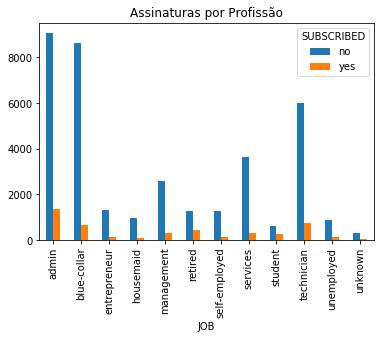

In [13]:
%matplotlib inline

plt.figure(figsize=(12, 5))

pd.crosstab(df['JOB'], df['SUBSCRIBED']).plot(kind='bar')

plt.title('Assinaturas por Profissão')

plt.show()

### MARITAL_STATUS

In [14]:
df.groupby('MARITAL_STATUS').mean()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS
MARITAL_STATUS,,,,,
divorced,44.899393,253.790330,2.61340,-0.787728,0.168690
married,42.307165,257.438623,2.57281,-0.780247,0.155608
single,33.158714,261.524378,2.53380,-0.643672,0.211359
unknown,40.275000,312.725000,3.18750,-0.400000,0.275000


In [15]:
subscribed_by_marital_status = df.groupby(['MARITAL_STATUS', 'SUBSCRIBED'])['SUBSCRIBED'].count().to_frame()

subscribed_by_marital_status['perc'] = (subscribed_by_marital_status / df.shape[0]) * 100

subscribed_by_marital_status

SUBSCRIBED       perc
MARITAL_STATUS SUBSCRIBED                       
divorced       no                4136  10.041760
               yes                476   1.155676
married        no               22396  54.375061
               yes               2532   6.147422
single         no                9948  24.152666
               yes               1620   3.933184
unknown        no                  68   0.165097
               yes                 12   0.029135

<Figure size 864x360 with 0 Axes>

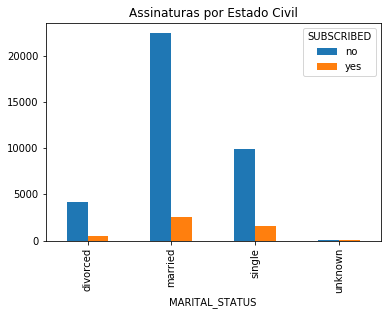

In [16]:
plt.figure(figsize=(12, 5))

pd.crosstab(df['MARITAL_STATUS'], df['SUBSCRIBED']).plot(kind='bar')

plt.title('Assinaturas por Estado Civil')

plt.show()

### EDUCATION

In [17]:
df.groupby('EDUCATION').mean()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS
EDUCATION,,,,,
basic_4y,47.596504,264.827826,2.600575,-0.770115,0.147031
basic_6y,40.448953,264.414485,2.556283,-0.870855,0.129145
basic_9y,39.061208,261.291811,2.532341,-0.850289,0.141439
high_school,37.998213,260.886810,2.568576,-0.749343,0.185917
illiterate,48.500000,276.777778,2.277778,-0.611111,0.111111
professional_course,40.080107,252.533855,2.586115,-0.706466,0.163075
university_degree,38.879191,253.223373,2.563527,-0.690664,0.192390
unknown,43.481225,262.390526,2.596187,-0.554593,0.226459


In [18]:
subscribed_by_education = df.groupby(['EDUCATION', 'SUBSCRIBED'])['SUBSCRIBED'].count().to_frame()

subscribed_by_education['perc'] = (subscribed_by_education / df.shape[0]) * 100

subscribed_by_education

SUBSCRIBED       perc
EDUCATION           SUBSCRIBED                       
basic_4y            no                3748   9.099738
                    yes                428   1.039138
basic_6y            no                2104   5.108284
                    yes                188   0.456444
basic_9y            no                5572  13.528212
                    yes                473   1.148393
high_school         no                8484  20.598232
                    yes               1031   2.503156
illiterate          no                  14   0.033990
                    yes                  4   0.009712
professional_course no                4648  11.284840
                    yes                595   1.444596
university_degree   no               10498  25.488006
                    yes               1670   4.054579
unknown             no                1480   3.593280
                    yes                251   0.609401

<Figure size 864x360 with 0 Axes>

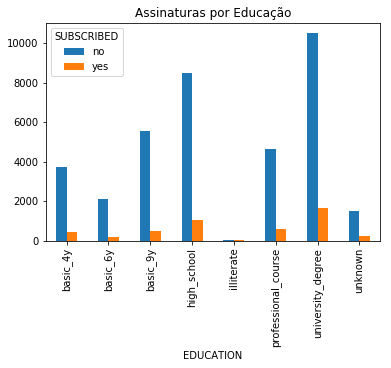

In [19]:
plt.figure(figsize=(12, 5))

pd.crosstab(df['EDUCATION'], df['SUBSCRIBED']).plot(kind='bar')

plt.title('Assinaturas por Educação')

plt.show()

### DEFAULT

In [20]:
df.groupby('DEFAULT').mean()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS
DEFAULT,,,,,
no,39.140635,259.842549,2.520744,-0.687278,0.199030
unknown,43.371990,252.435035,2.745609,-0.949285,0.074096
yes,42.333333,103.333333,1.333333,-1.000000,0.333333


In [21]:
subscribed_by_default = df.groupby(['DEFAULT', 'SUBSCRIBED'])['SUBSCRIBED'].count().to_frame()

subscribed_by_default['perc'] = (subscribed_by_default / df.shape[0]) * 100

subscribed_by_default

SUBSCRIBED       perc
DEFAULT SUBSCRIBED                       
no      no               28391  68.930271
        yes               4197  10.189861
unknown no                8154  19.797028
        yes                443   1.075556
yes     no                   3   0.007284

<Figure size 864x360 with 0 Axes>

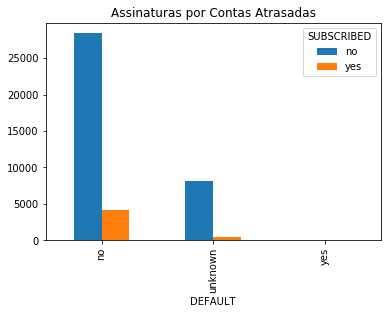

In [22]:
plt.figure(figsize=(12, 5))

pd.crosstab(df['DEFAULT'], df['SUBSCRIBED']).plot(kind='bar')

plt.title('Assinaturas por Contas Atrasadas')

plt.show()

### HOUSING

In [23]:
df.groupby('HOUSING').mean()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS
HOUSING,,,,,
no,40.044195,260.663677,2.601010,-0.749973,0.161153
unknown,39.951515,250.194949,2.560606,-0.759596,0.184848
yes,40.010011,256.603217,2.539071,-0.734288,0.182610


In [24]:
subscribed_by_housing = df.groupby(['HOUSING', 'SUBSCRIBED'])['SUBSCRIBED'].count().to_frame()

subscribed_by_housing['perc'] = (subscribed_by_housing / df.shape[0]) * 100

subscribed_by_housing

SUBSCRIBED       perc
HOUSING SUBSCRIBED                       
no      no               16596  40.293289
        yes               2026   4.918908
unknown no                 883   2.143828
        yes                107   0.259784
yes     no               19069  46.297465
        yes               2507   6.086724

<Figure size 864x360 with 0 Axes>

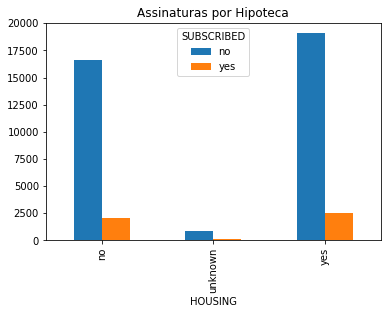

In [25]:
plt.figure(figsize=(12, 5))

pd.crosstab(df['HOUSING'], df['SUBSCRIBED']).plot(kind='bar')

plt.title('Assinaturas por Hipoteca')

plt.show()

### LOAN

In [26]:
df.groupby('LOAN').mean()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS
LOAN,,,,,
no,40.058822,258.507246,2.561414,-0.739853,0.173078
unknown,39.951515,250.194949,2.560606,-0.759596,0.184848
yes,39.846671,258.359315,2.602273,-0.750800,0.170455


In [27]:
subscribed_by_loan = df.groupby(['LOAN', 'SUBSCRIBED'])['SUBSCRIBED'].count().to_frame()

subscribed_by_loan['perc'] = (subscribed_by_loan / df.shape[0]) * 100

subscribed_by_loan

SUBSCRIBED       perc
LOAN    SUBSCRIBED                       
no      no               30100  73.079538
        yes               3850   9.347383
unknown no                 883   2.143828
        yes                107   0.259784
yes     no                5565  13.511217
        yes                683   1.658250

<Figure size 864x360 with 0 Axes>

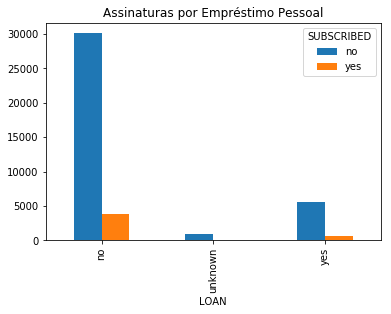

In [28]:
plt.figure(figsize=(12, 5))

pd.crosstab(df['LOAN'], df['SUBSCRIBED']).plot(kind='bar')

plt.title('Assinaturas por Empréstimo Pessoal')

plt.show()

### CONTACT

In [29]:
df.groupby('CONTACT').mean()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS
CONTACT,,,,,
cellular,39.968559,263.527846,2.405026,-0.624694,0.252869
telephone,40.120513,249.173823,2.850106,-0.945826,0.034100


In [30]:
subscribed_by_contact = df.groupby(['CONTACT', 'SUBSCRIBED'])['SUBSCRIBED'].count().to_frame()

subscribed_by_contact['perc'] = (subscribed_by_contact / df.shape[0]) * 100

subscribed_by_contact

SUBSCRIBED       perc
CONTACT   SUBSCRIBED                       
cellular  no               22291  54.120132
          yes               3853   9.354666
telephone no               14257  34.614451
          yes                787   1.910751

<Figure size 864x360 with 0 Axes>

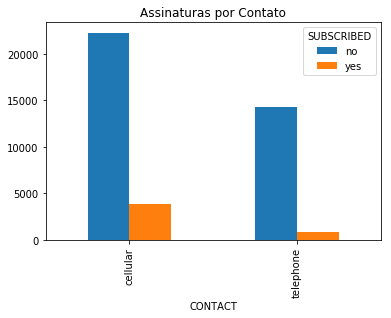

In [31]:
plt.figure(figsize=(12, 5))

pd.crosstab(df['CONTACT'], df['SUBSCRIBED']).plot(kind='bar')

plt.title('Assinaturas por Contato')

plt.show()

### MONTH

In [32]:
df.groupby('MONTH').mean()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS
MONTH,,,,,
apr,40.593845,293.200608,1.947188,-0.719605,0.323328
aug,41.644221,232.430722,2.666559,-0.737779,0.115410
dec,47.307692,345.609890,2.159341,0.807692,0.615385
jul,39.035545,273.426122,3.160998,-0.850990,0.047115
jun,39.766077,242.561301,3.072208,-0.820233,0.083114
mar,40.778388,245.946886,2.203297,0.289377,0.483516
may,39.031084,261.231752,2.439756,-0.868110,0.164209
nov,40.965618,245.855645,1.909290,-0.719581,0.293587
oct,44.171309,288.367688,1.545961,0.572423,0.647632


In [33]:
subscribed_by_month = df.groupby(['MONTH', 'SUBSCRIBED'])['SUBSCRIBED'].count().to_frame()

subscribed_by_month['perc'] = (subscribed_by_month / df.shape[0]) * 100

subscribed_by_month

SUBSCRIBED       perc
MONTH SUBSCRIBED                       
apr   no                2093   5.081577
      yes                539   1.308634
aug   no                5523  13.409245
      yes                655   1.590269
dec   no                  93   0.225794
      yes                 89   0.216082
jul   no                6525  15.841993
      yes                649   1.575702
jun   no                4759  11.554336
      yes                559   1.357191
mar   no                 270   0.655531
      yes                276   0.670098
may   no               12883  31.278528
      yes                886   2.151112
nov   no                3685   8.946781
      yes                416   1.010003
oct   no                 403   0.978440
      yes                315   0.764786
sep   no                 314   0.762358
      yes                256   0.621540

<Figure size 864x360 with 0 Axes>

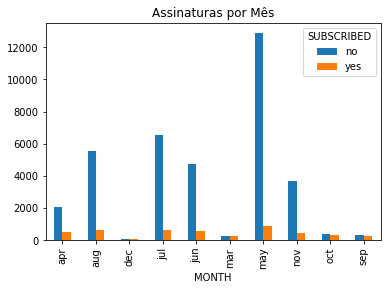

In [34]:
plt.figure(figsize=(12, 5))

pd.crosstab(df['MONTH'], df['SUBSCRIBED']).plot(kind='bar')

plt.title('Assinaturas por Mês')

plt.show()

### DAY_OF_WEEK

In [35]:
df.groupby('DAY_OF_WEEK').mean()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS
DAY_OF_WEEK,,,,,
fri,40.177846,252.748818,2.719944,-0.776543,0.177463
mon,40.412497,246.568358,2.645760,-0.736434,0.171012
thu,39.591557,265.674591,2.595268,-0.720747,0.174417
tue,40.427441,260.455995,2.426823,-0.729419,0.173053
wed,39.526801,265.883206,2.449840,-0.749570,0.169044


In [36]:
subscribed_by_day_of_week = df.groupby(['DAY_OF_WEEK', 'SUBSCRIBED'])['SUBSCRIBED'].count().to_frame()

subscribed_by_day_of_week['perc'] = (subscribed_by_day_of_week / df.shape[0]) * 100

subscribed_by_day_of_week

SUBSCRIBED       perc
DAY_OF_WEEK SUBSCRIBED                       
fri         no                6981  16.949111
            yes                846   2.053996
mon         no                7667  18.614645
            yes                847   2.056424
thu         no                7578  18.398563
            yes               1045   2.537147
tue         no                7137  17.327862
            yes                953   2.313781
wed         no                7185  17.444401
            yes                949   2.304069

<Figure size 864x360 with 0 Axes>

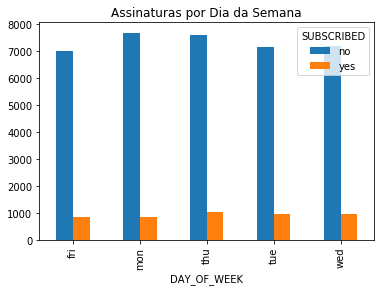

In [37]:
plt.figure(figsize=(12, 5))

pd.crosstab(df['DAY_OF_WEEK'], df['SUBSCRIBED']).plot(kind='bar')

plt.title('Assinaturas por Dia da Semana')

plt.show()

### POUTCOME

In [38]:
df.groupby('POUTCOME').mean()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS
POUTCOME,,,,,
failure,39.946143,248.112888,2.005174,-0.627940,1.168627
nonexistent,39.956190,257.082192,2.664145,-1.000000,0.000000
success,42.023307,320.941733,1.808449,5.587764,1.569556


In [39]:
subscribed_by_poutcome = df.groupby(['POUTCOME', 'SUBSCRIBED'])['SUBSCRIBED'].count().to_frame()

subscribed_by_poutcome['perc'] = (subscribed_by_poutcome / df.shape[0]) * 100

subscribed_by_poutcome

SUBSCRIBED       perc
POUTCOME    SUBSCRIBED                       
failure     no                3647   8.854521
            yes                605   1.468874
nonexistent no               32422  78.717102
            yes               3141   7.626008
success     no                 479   1.162960
            yes                894   2.170535

<Figure size 864x360 with 0 Axes>

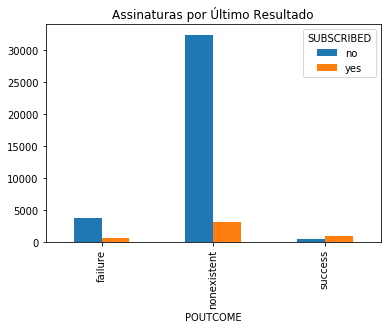

In [40]:
plt.figure(figsize=(12, 5))

pd.crosstab(df['POUTCOME'], df['SUBSCRIBED']).plot(kind='bar')

plt.title('Assinaturas por Último Resultado')

plt.show()

### EMP_VAR_RATE

In [41]:
df.groupby('EMP_VAR_RATE').mean()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS
EMP_VAR_RATE,,,,,
-0_1,40.649471,242.943524,1.895194,-0.951127,0.199566
-0_2,42.100000,121.000000,1.000000,-1.000000,0.100000
-1_1,41.176378,309.234646,1.822047,1.872441,1.193701
-1_7,40.945666,301.712807,1.943079,1.843467,1.051746
-1_8,38.486934,266.205575,2.222997,-0.645253,0.367596
-2_9,40.492483,253.218882,1.785328,-0.129886,0.408900
-3,47.610465,358.668605,2.226744,0.912791,0.645349
-3_4,45.490196,274.387488,1.693744,0.298786,0.606909
1_1,40.327580,265.111297,2.512560,-1.000000,0.000000


In [42]:
df.head()

,AGE,JOB,MARITAL_STATUS,EDUCATION,DEFAULT,HOUSING,LOAN,CONTACT,MONTH,DAY_OF_WEEK,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,EMP_VAR_RATE,CONS_PRICE_IDX,CONS_CONF_IDX,SUBSCRIBED
0,56,housemaid,married,basic_4y,no,no,no,telephone,may,mon,261,1,-1,0,nonexistent,1_1,93.994,-36_4,no
1,57,services,married,high_school,unknown,no,no,telephone,may,mon,149,1,-1,0,nonexistent,1_1,93.994,-36_4,no
2,37,services,married,high_school,no,yes,no,telephone,may,mon,226,1,-1,0,nonexistent,1_1,93.994,-36_4,no
3,40,admin,married,basic_6y,no,no,no,telephone,may,mon,151,1,-1,0,nonexistent,1_1,93.994,-36_4,no
4,56,services,married,high_school,no,no,yes,telephone,may,mon,307,1,-1,0,nonexistent,1_1,93.994,-36_4,no


In [43]:
df['EMP_VAR_RATE'] = np.float64(df['EMP_VAR_RATE'].apply(lambda x: x.replace('_', '.')))

In [44]:
df.head()

,AGE,JOB,MARITAL_STATUS,EDUCATION,DEFAULT,HOUSING,LOAN,CONTACT,MONTH,DAY_OF_WEEK,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,EMP_VAR_RATE,CONS_PRICE_IDX,CONS_CONF_IDX,SUBSCRIBED
0,56,housemaid,married,basic_4y,no,no,no,telephone,may,mon,261,1,-1,0,nonexistent,1.1,93.994,-36_4,no
1,57,services,married,high_school,unknown,no,no,telephone,may,mon,149,1,-1,0,nonexistent,1.1,93.994,-36_4,no
2,37,services,married,high_school,no,yes,no,telephone,may,mon,226,1,-1,0,nonexistent,1.1,93.994,-36_4,no
3,40,admin,married,basic_6y,no,no,no,telephone,may,mon,151,1,-1,0,nonexistent,1.1,93.994,-36_4,no
4,56,services,married,high_school,no,no,yes,telephone,may,mon,307,1,-1,0,nonexistent,1.1,93.994,-36_4,no


In [45]:
subscribed_by_empvarrate = df.groupby(['EMP_VAR_RATE', 'SUBSCRIBED'])['SUBSCRIBED'].count().to_frame()

subscribed_by_empvarrate['perc'] = (subscribed_by_empvarrate / df.shape[0]) * 100

subscribed_by_empvarrate

SUBSCRIBED       perc
EMP_VAR_RATE SUBSCRIBED                       
-3.4         no                 617   1.498009
             yes                454   1.102263
-3.0         no                  84   0.203943
             yes                 88   0.213654
-2.9         no                1069   2.595416
             yes                594   1.442168
-1.8         no                7723  18.750607
             yes               1461   3.547150
-1.7         no                 370   0.898320
             yes                403   0.978440
-1.1         no                 334   0.810916
             yes                301   0.730795
-0.2         no                   9   0.021851
             yes                  1   0.002428
-0.1         no                3451   8.378654
             yes                232   0.563271
 1.1         no                7523  18.265029
             yes                240   0.582694
 1.4         no               15368  37.311838
             yes                866   2.102554

<Figure size 864x360 with 0 Axes>

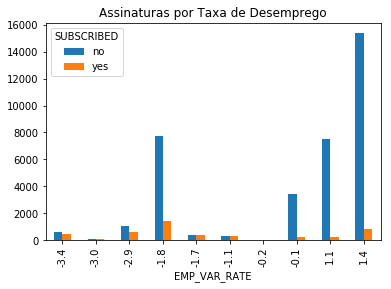

In [46]:
plt.figure(figsize=(12, 5))

pd.crosstab(df['EMP_VAR_RATE'], df['SUBSCRIBED']).plot(kind='bar')

plt.title('Assinaturas por Taxa de Desemprego')

plt.show()

### CONS_PRICE_IDX

In [47]:
df.groupby('CONS_PRICE_IDX').mean()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS,EMP_VAR_RATE
CONS_PRICE_IDX,,,,,,
92.20100000000001,43.610390,249.927273,1.724675,0.238961,0.545455,-2.9
92.37899999999999,47.363296,281.250936,1.677903,0.056180,0.494382,-3.4
92.431,45.671141,279.807606,1.521253,0.029083,0.503356,-3.4
92.469,40.230337,289.589888,2.185393,-0.179775,0.258427,-2.9
92.649,43.862745,262.467787,1.921569,0.817927,0.820728,-3.4
92.713,47.610465,358.668605,2.226744,0.912791,0.645349,-3.0
92.89299999999999,36.378762,245.231192,2.595486,-0.786458,0.325521,-1.8
92.963,37.200000,247.709091,1.751049,-0.514685,0.299301,-2.9
93.369,42.007576,278.037879,1.875000,1.518939,0.909091,-1.8


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 19 columns):
AGE               41188 non-null int64
JOB               41188 non-null object
MARITAL_STATUS    41188 non-null object
EDUCATION         41188 non-null object
DEFAULT           41188 non-null object
HOUSING           41188 non-null object
LOAN              41188 non-null object
CONTACT           41188 non-null object
MONTH             41188 non-null object
DAY_OF_WEEK       41188 non-null object
DURATION          41188 non-null int64
CAMPAIGN          41188 non-null int64
PDAYS             41188 non-null int64
PREVIOUS          41188 non-null int64
POUTCOME          41188 non-null object
EMP_VAR_RATE      41188 non-null float64
CONS_PRICE_IDX    41188 non-null object
CONS_CONF_IDX     41188 non-null object
SUBSCRIBED        41188 non-null object
dtypes: float64(1), int64(5), object(13)
memory usage: 6.0+ MB


In [49]:
df['CONS_PRICE_IDX'].unique()

array(['93.994', '94.465', '93.918', '93.444', '93.798', '93_2', '92.756',
       '92.843', '93.075', '92.893', 92.89299999999999, 92.963, 92.469,
       92.20100000000001, 92.37899999999999, 92.431, 92.649, 92.713,
       93.369, 93.749, 93.876, 94.055, 94.215, 94.027, 94.199, 94.601,
       94.76700000000001], dtype=object)

In [50]:
df['CONS_PRICE_IDX'] = np.float64(df['CONS_PRICE_IDX'].apply(lambda x: str(x).replace('_', '.')))

In [51]:
df['CONS_PRICE_IDX'].unique()

array([93.994, 94.465, 93.918, 93.444, 93.798, 93.2  , 92.756, 92.843,
       93.075, 92.893, 92.893, 92.963, 92.469, 92.201, 92.379, 92.431,
       92.649, 92.713, 93.369, 93.749, 93.876, 94.055, 94.215, 94.027,
       94.199, 94.601, 94.767])

In [52]:
subscribed_by_cpi = df.groupby(['CONS_PRICE_IDX', 'SUBSCRIBED'])['SUBSCRIBED'].count().to_frame()

subscribed_by_cpi['perc'] = (subscribed_by_cpi / df.shape[0]) * 100

subscribed_by_cpi

SUBSCRIBED       perc
CONS_PRICE_IDX SUBSCRIBED                       
92.201         no                 506   1.228513
               yes                264   0.640963
92.379         no                 161   0.390891
               yes                106   0.257357
92.431         no                 267   0.648247
               yes                180   0.437020
92.469         no                 112   0.271924
               yes                 66   0.160241
92.649         no                 189   0.458872
               yes                168   0.407886
92.713         no                  84   0.203943
               yes                 88   0.213654
92.756         no                   9   0.021851
               yes                  1   0.002428
92.843         no                 156   0.378751
               yes                126   0.305914
92.893         no                3116   7.565310
               yes                340   0.825483
               no                2154   5.229679
               yes                184   0.446732
92.963         no                 451   1.094979
               yes                264   0.640963
93.075         no                2016   4.894630
               yes                442   1.073128
93.200         no                3426   8.317957
               yes                190   0.461299
93.369         no                 114   0.276780
               yes                150   0.364184
93.444         no                4904  11.906380
               yes                271   0.657959
93.749         no                  77   0.186948
               yes                 97   0.235505
93.798         no                  25   0.060697
               yes                 42   0.101971
93.876         no                  90   0.218510
               yes                122   0.296203
93.918         no                6278  15.242304
               yes                407   0.988152
93.994         no                7523  18.265029
               yes                240   0.582694
94.027         no                 113   0.274352
               yes                120   0.291347
94.055         no                 122   0.296203
               yes                107   0.259784
94.199         no                 153   0.371467
               yes                150   0.364184
94.215         no                 135   0.327765
               yes                176   0.427309
94.465         no                4186  10.163154
               yes                188   0.456444
94.601         no                 111   0.269496
               yes                 93   0.225794
94.767         no                  70   0.169952
               yes                 58   0.140818

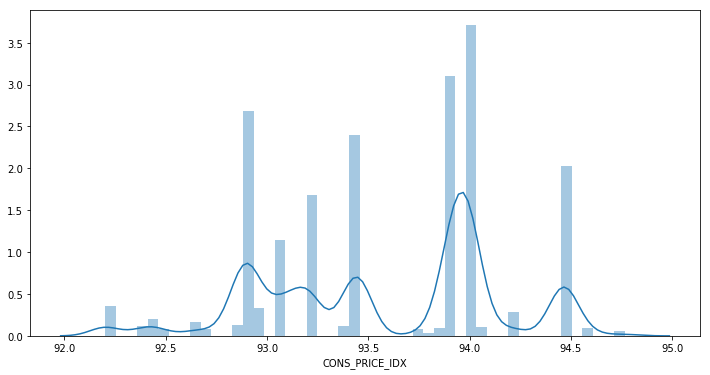

In [53]:
plt.figure(figsize=(12, 6))

sns.distplot(df['CONS_PRICE_IDX'])

plt.show()

### CONS_CONF_IDX

In [54]:
df.groupby('CONS_CONF_IDX').mean()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS,EMP_VAR_RATE,CONS_PRICE_IDX
CONS_CONF_IDX,,,,,,,
-26_9,45.671141,279.807606,1.521253,0.029083,0.503356,-3.4,92.431
-29_8,47.363296,281.250936,1.677903,0.056180,0.494382,-3.4,92.379
-30_1,43.862745,262.467787,1.921569,0.817927,0.820728,-3.4,92.649
-31_4,43.610390,249.927273,1.724675,0.238961,0.545455,-2.9,92.201
-33,47.610465,358.668605,2.226744,0.912791,0.645349,-3.0,92.713
-33_6,40.230337,289.589888,2.185393,-0.179775,0.258427,-2.9,92.469
-34_6,46.591954,322.793103,2.109195,1.362069,0.718391,-1.8,93.749
-34_8,42.007576,278.037879,1.875000,1.518939,0.909091,-1.8,93.369
-36_1,41.325217,226.944928,2.840966,-1.000000,0.000000,1.4,93.444


In [55]:
df['CONS_CONF_IDX'] = np.float64(df['CONS_CONF_IDX'].apply(lambda x: str(x).replace('_', '.')))

In [56]:
subscribed_by_cci = df.groupby(['CONS_CONF_IDX', 'SUBSCRIBED'])['SUBSCRIBED'].count().to_frame()

subscribed_by_cci['perc'] = (subscribed_by_cci / df.shape[0]) * 100

subscribed_by_cci

SUBSCRIBED       perc
CONS_CONF_IDX SUBSCRIBED                       
-50.8         no                  70   0.169952
              yes                 58   0.140818
-50.0         no                 156   0.378751
              yes                126   0.305914
-49.5         no                 111   0.269496
              yes                 93   0.225794
-47.1         no                2016   4.894630
              yes                442   1.073128
-46.2         no                5270  12.794989
              yes                524   1.272215
-45.9         no                   9   0.021851
              yes                  1   0.002428
-42.7         no                6278  15.242304
              yes                407   0.988152
-42.0         no                3426   8.317957
              yes                190   0.461299
-41.8         no                4186  10.163154
              yes                188   0.456444
-40.8         no                 451   1.094979
              yes                264   0.640963
-40.4         no                  25   0.060697
              yes                 42   0.101971
-40.3         no                 135   0.327765
              yes                176   0.427309
-40.0         no                  90   0.218510
              yes                122   0.296203
-39.8         no                 122   0.296203
              yes                107   0.259784
-38.3         no                 113   0.274352
              yes                120   0.291347
-37.5         no                 153   0.371467
              yes                150   0.364184
-36.4         no                7523  18.265029
              yes                240   0.582694
-36.1         no                4904  11.906380
              yes                271   0.657959
-34.8         no                 114   0.276780
              yes                150   0.364184
-34.6         no                  77   0.186948
              yes                 97   0.235505
-33.6         no                 112   0.271924
              yes                 66   0.160241
-33.0         no                  84   0.203943
              yes                 88   0.213654
-31.4         no                 506   1.228513
              yes                264   0.640963
-30.1         no                 189   0.458872
              yes                168   0.407886
-29.8         no                 161   0.390891
              yes                106   0.257357
-26.9         no                 267   0.648247
              yes                180   0.437020

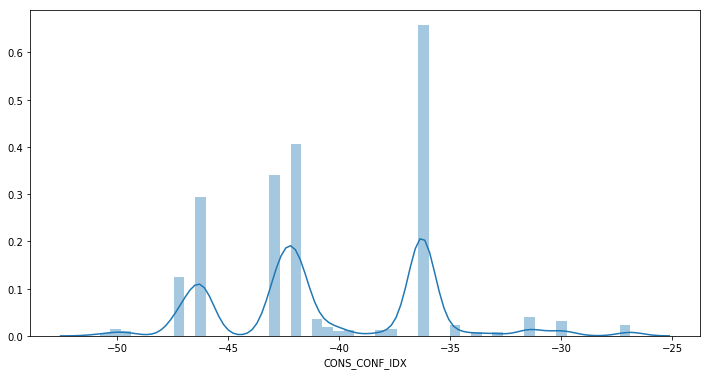

In [57]:
plt.figure(figsize=(12, 6))

sns.distplot(df['CONS_CONF_IDX'])

plt.show()

### SUBSCRIBED

no     36548
yes     4640
Name: SUBSCRIBED, dtype: int64


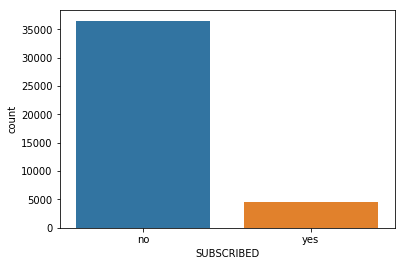

In [58]:
print(df['SUBSCRIBED'].value_counts())

sns.countplot(df['SUBSCRIBED'])

plt.show()

Desbalanceada

In [59]:
feat_num = df.select_dtypes(exclude=np.object)
feat_num.head()

,AGE,DURATION,CAMPAIGN,PDAYS,PREVIOUS,EMP_VAR_RATE,CONS_PRICE_IDX,CONS_CONF_IDX
0,56,261,1,-1,0,1.1,93.994,-36.4
1,57,149,1,-1,0,1.1,93.994,-36.4
2,37,226,1,-1,0,1.1,93.994,-36.4
3,40,151,1,-1,0,1.1,93.994,-36.4
4,56,307,1,-1,0,1.1,93.994,-36.4


In [60]:
df['PDAYS'].replace('-1', 0, inplace=True)

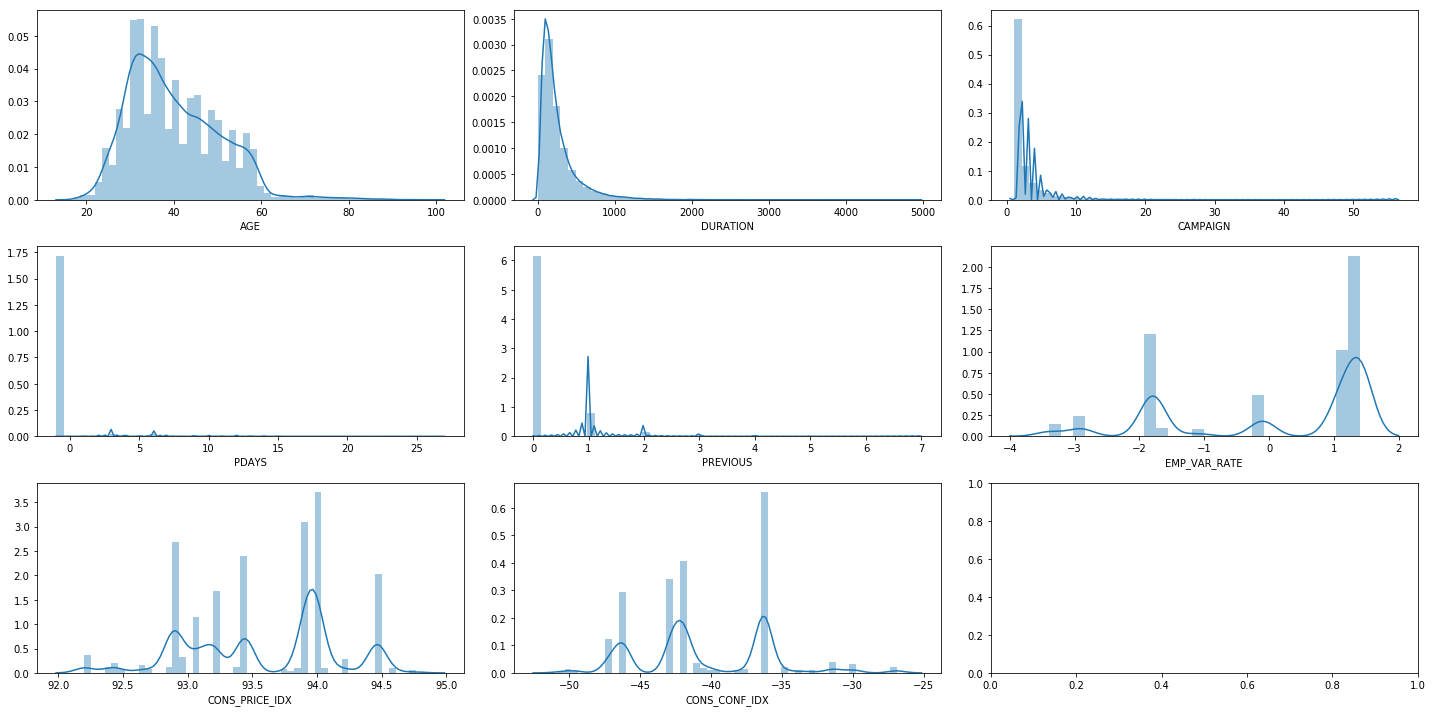

In [61]:
r, c = 0, 0

_, axs = plt.subplots(3, 3, figsize=(20, 10))

for i in feat_num.columns:
    sns.distplot(feat_num[i], ax=axs[r, c])
    
    if c == 2:
        r += 1
        c = 0
    else:
        c += 1

plt.tight_layout()

plt.show()

In [62]:
df['DURATION'] = np.log1p(df['DURATION'])

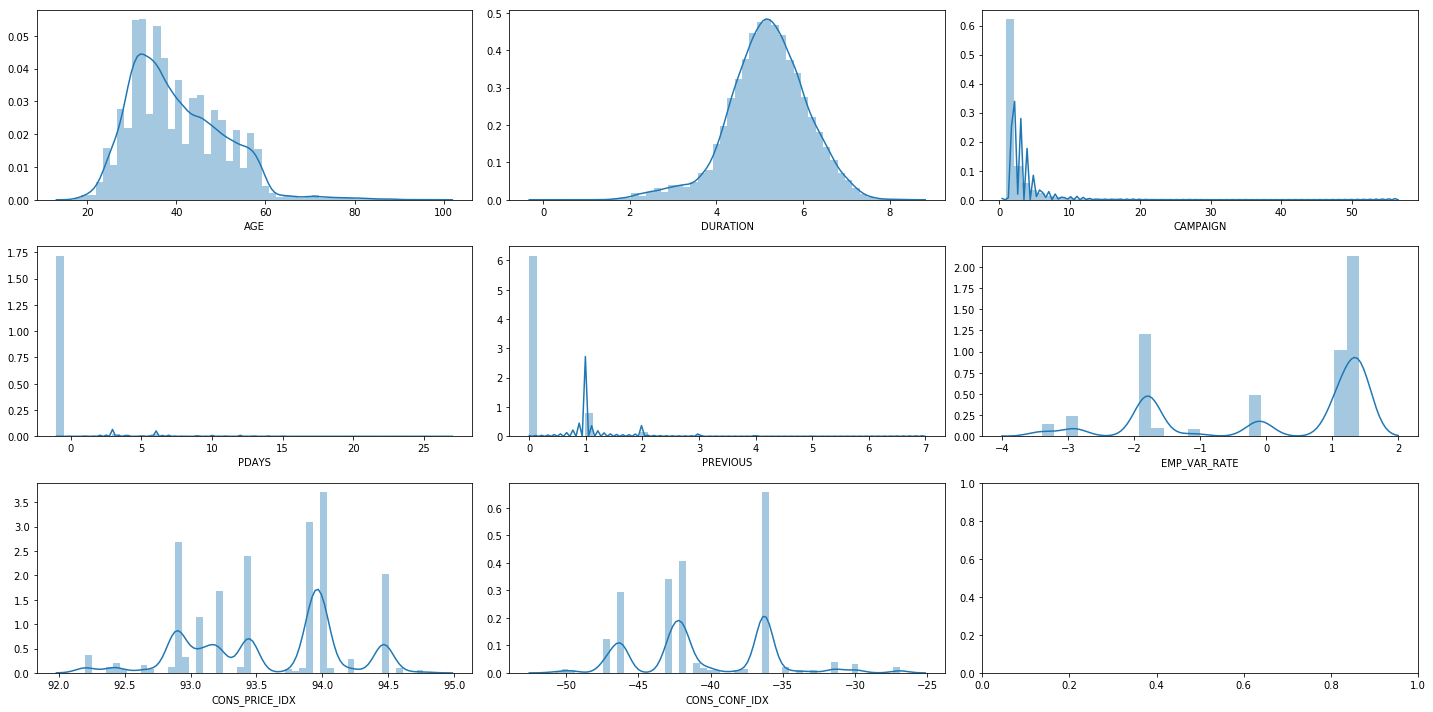

In [63]:
feat_num = df.select_dtypes(exclude=np.object)

r, c = 0, 0

_, axs = plt.subplots(3, 3, figsize=(20, 10))

for i in feat_num.columns:
    sns.distplot(feat_num[i], ax=axs[r, c])
    
    if c == 2:
        r += 1
        c = 0
    else:
        c += 1

plt.tight_layout()

plt.show()

## Transformações

In [64]:
cols = ['MARITAL_STATUS', 'DEFAULT', 'HOUSING', 'LOAN', 'CONTACT', 'POUTCOME']
for i in cols:
    label = LabelEncoder()
    df[i] = label.fit_transform(df[i])

In [65]:
df['SUBSCRIBED'] = df['SUBSCRIBED'].apply(lambda x: 1 if x == 'yes' else 0)

In [66]:
df['MONTH'] = df['MONTH'].apply(lambda x: strptime(x,'%b').tm_mon)

In [67]:
df['DAY_OF_WEEK'] = df['DAY_OF_WEEK'].apply(lambda x: strptime(x,'%a').tm_mon)

In [68]:
df.head()

,AGE,JOB,MARITAL_STATUS,EDUCATION,DEFAULT,HOUSING,LOAN,CONTACT,MONTH,DAY_OF_WEEK,DURATION,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,EMP_VAR_RATE,CONS_PRICE_IDX,CONS_CONF_IDX,SUBSCRIBED
0,56,housemaid,1,basic_4y,0,0,0,1,5,1,5.568345,1,-1,0,1,1.1,93.994,-36.4,0
1,57,services,1,high_school,1,0,0,1,5,1,5.010635,1,-1,0,1,1.1,93.994,-36.4,0
2,37,services,1,high_school,0,2,0,1,5,1,5.424950,1,-1,0,1,1.1,93.994,-36.4,0
3,40,admin,1,basic_6y,0,0,0,1,5,1,5.023881,1,-1,0,1,1.1,93.994,-36.4,0
4,56,services,1,high_school,0,0,2,1,5,1,5.730100,1,-1,0,1,1.1,93.994,-36.4,0


In [69]:
joblib.dump(df, '../backup/df.gz', compress=True)

['../backup/df.gz']

In [ ]:
df = joblib.load('../backup/df,gz')

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 19 columns):
AGE               41188 non-null int64
JOB               41188 non-null object
MARITAL_STATUS    41188 non-null int64
EDUCATION         41188 non-null object
DEFAULT           41188 non-null int64
HOUSING           41188 non-null int64
LOAN              41188 non-null int64
CONTACT           41188 non-null int64
MONTH             41188 non-null int64
DAY_OF_WEEK       41188 non-null int64
DURATION          41188 non-null float64
CAMPAIGN          41188 non-null int64
PDAYS             41188 non-null int64
PREVIOUS          41188 non-null int64
POUTCOME          41188 non-null int64
EMP_VAR_RATE      41188 non-null float64
CONS_PRICE_IDX    41188 non-null float64
CONS_CONF_IDX     41188 non-null float64
SUBSCRIBED        41188 non-null int64
dtypes: float64(4), int64(13), object(2)
memory usage: 6.0+ MB


In [72]:
df = pd.get_dummies(df)

In [73]:
df.head()

,AGE,MARITAL_STATUS,DEFAULT,HOUSING,LOAN,CONTACT,MONTH,DAY_OF_WEEK,DURATION,CAMPAIGN,...,JOB_unemployed,JOB_unknown,EDUCATION_basic_4y,EDUCATION_basic_6y,EDUCATION_basic_9y,EDUCATION_high_school,EDUCATION_illiterate,EDUCATION_professional_course,EDUCATION_university_degree,EDUCATION_unknown
0,56,1,0,0,0,1,5,1,5.568345,1,...,0,0,1,0,0,0,0,0,0,0
1,57,1,1,0,0,1,5,1,5.010635,1,...,0,0,0,0,0,1,0,0,0,0
2,37,1,0,2,0,1,5,1,5.424950,1,...,0,0,0,0,0,1,0,0,0,0
3,40,1,0,0,0,1,5,1,5.023881,1,...,0,0,0,1,0,0,0,0,0,0
4,56,1,0,0,2,1,5,1,5.730100,1,...,0,0,0,0,0,1,0,0,0,0


## Modelagem

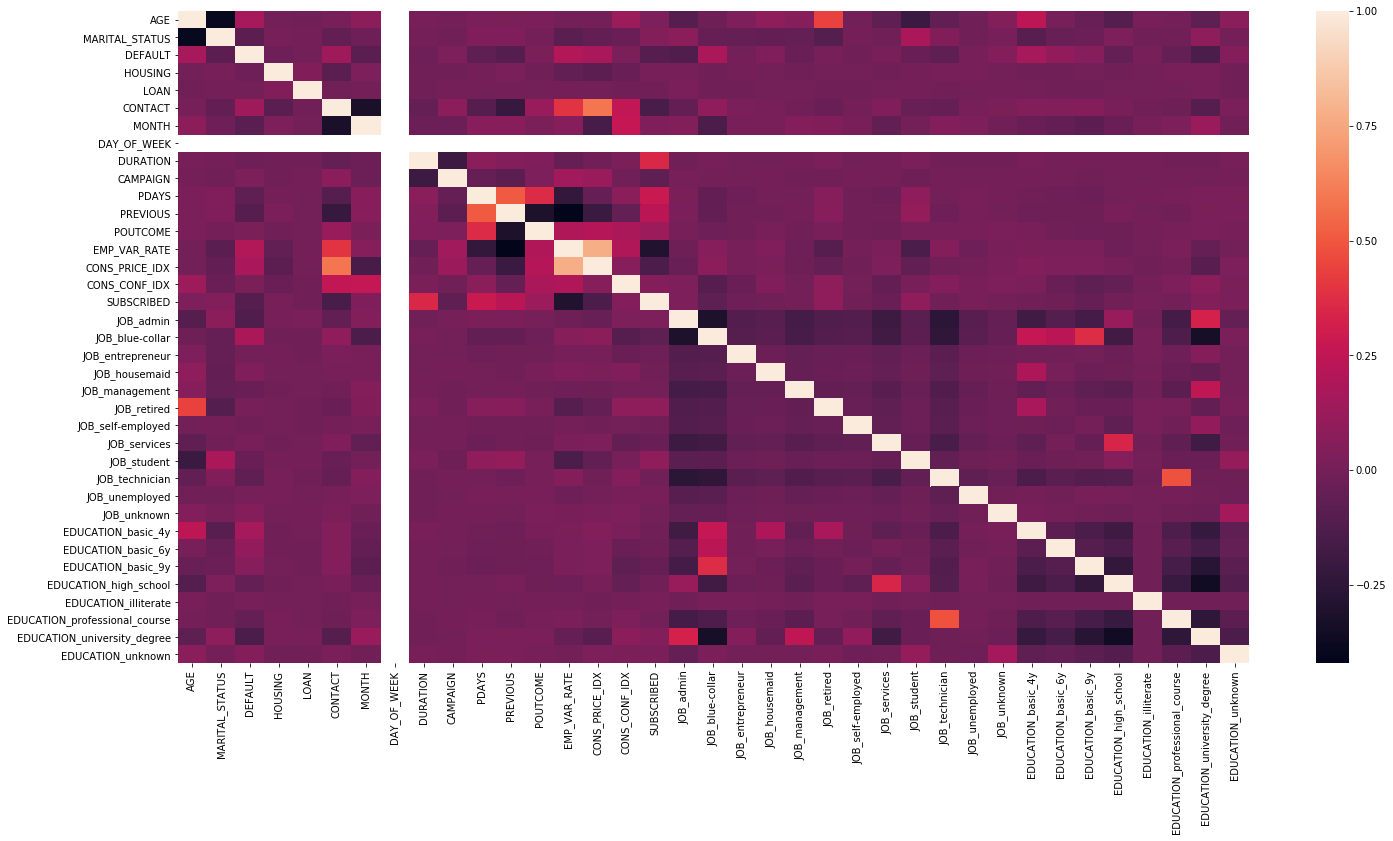

In [76]:
plt.figure(figsize=(24, 12))

sns.heatmap(df.corr())

plt.show()

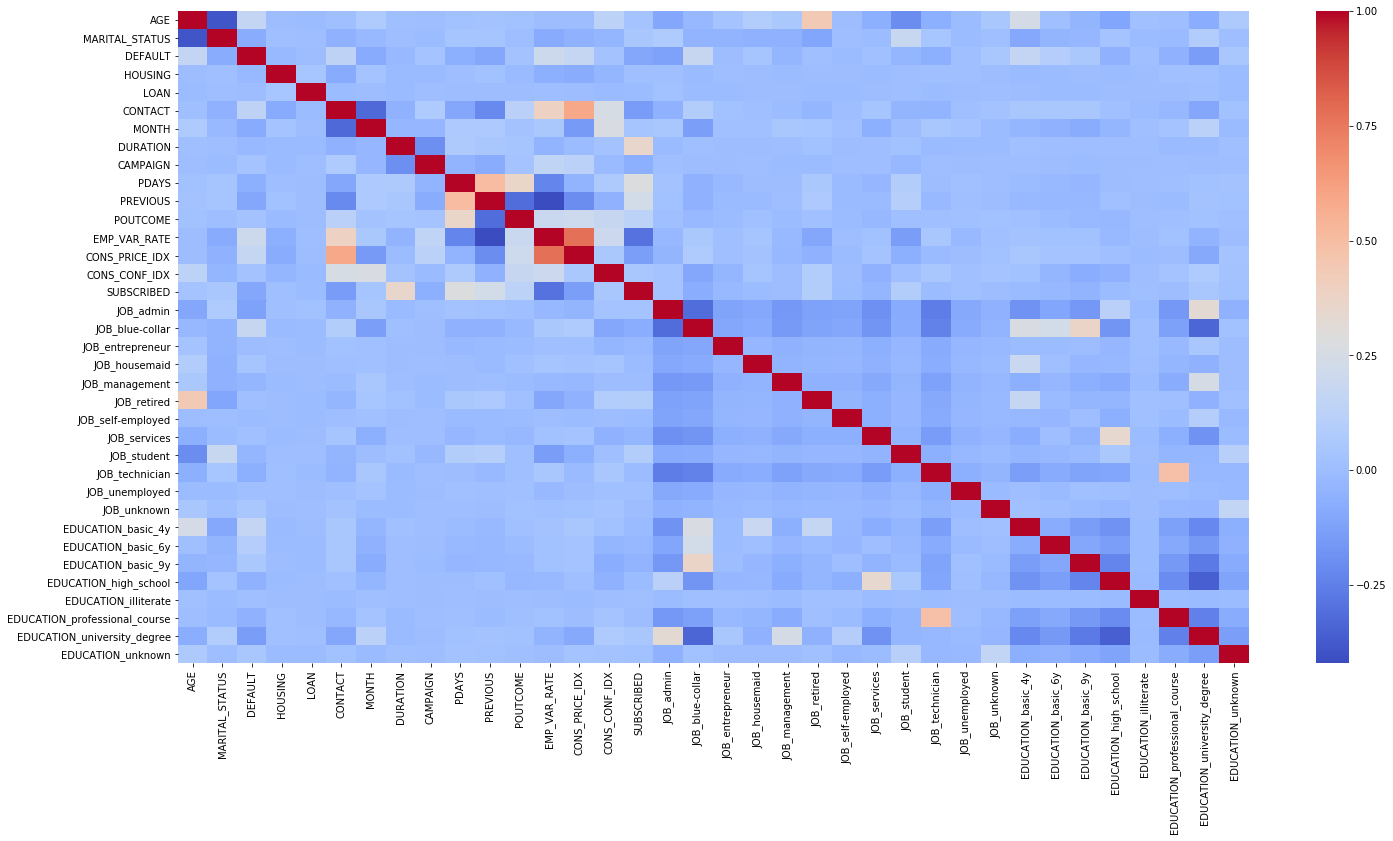

In [81]:
if 'DAY_OF_WEEK' in df.columns:
    del(df['DAY_OF_WEEK'])

plt.figure(figsize=(24, 12))

sns.heatmap(df.corr(), cmap='coolwarm')

plt.show()

## Divisão dos dados

In [82]:
X, y = df.drop(['SUBSCRIBED'], axis=1), df['SUBSCRIBED']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [90]:
modelos = []

modelos.append(('LogisticRegression', LogisticRegression()))
modelos.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
modelos.append(('SVC [RBF]', SVC()))
modelos.append(('SVC [LINEAR]', SVC(kernel='linear')))
modelos.append(('SVC [POLY]', SVC(kernel='poly')))
modelos.append(('MLPClassifier', MLPClassifier()))
modelos.append(('RandomForestClassifier', RandomForestClassifier()))
modelos.append(('GradientBoostingClassifier', GradientBoostingClassifier()))

In [ ]:
for n, m in modelos:
    print('-' * 50)
    print(n)
    print('-' * 50)
    
    m.fit(X_train, y_train)
    
    y_pred = m.predict(X_test)
    
    print(confusion_matrix(y_test, y_pred))
    print('')
    print(classification_report(y_test, y_pred))

--------------------------------------------------
LogisticRegression
--------------------------------------------------
[[10611   288]
 [  915   543]]

              precision    recall  f1-score   support

           0       0.92      0.97      0.95     10899
           1       0.65      0.37      0.47      1458

   micro avg       0.90      0.90      0.90     12357
   macro avg       0.79      0.67      0.71     12357
weighted avg       0.89      0.90      0.89     12357

--------------------------------------------------
DecisionTreeClassifier
--------------------------------------------------
[[10155   744]
 [  725   733]]

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     10899
           1       0.50      0.50      0.50      1458

   micro avg       0.88      0.88      0.88     12357
   macro avg       0.71      0.72      0.72     12357
weighted avg       0.88      0.88      0.88     12357

------------------------------------